In [1]:
# 导包与数据预处理
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np  # 这里其实没用到，可以删掉（保留也不影响）

# =========================================================
# 1) 超参数与设备选择
# =========================================================
# device: 如果你的电脑有 NVIDIA GPU 且装了 CUDA，会用 GPU；否则用 CPU。
# 注意：CPU 训练 CIFAR10 会比较慢（你之前中断训练就是因为这个）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

NUM_EPOCHS = 150        # 训练轮数（epoch）：数据集完整训练多少遍
BATCH_SIZE = 128        # 每次喂给模型多少张图片（batch size）
LEARNING_RATE = 0.1  # 学习率（步子大小）

# =========================================================
# 2) 数据预处理与加载（含数据增强）
# =========================================================
# CIFAR10 原图大小是 32x32，RGB 三通道。
# transform_train：训练集用数据增强，让模型更鲁棒、降低过拟合风险。
# 数据增强的核心思想：在不改变图像本质内容的前提下，通过几何变换、色彩抖动等方式，凭空创造出
# 更多样的训练样本。这极大地扩充了数据集，是防止模型过拟合（Overfitting）最有效的方法之一。
transform_train = transforms.Compose([
    
    # (★ 新增) 随机裁剪，这是非常有效的增强手段
    # 先在原图 32x32 四周填充 4 个像素，变成 40x40
    # 然后随机裁剪回 32x32。这等效于小的随机平移和缩放。

    transforms.RandomCrop(32,padding=4),


    transforms.RandomHorizontalFlip(),            # 默认以p=50%的概率随机水平翻转（CIFAR10一般有效）
                                                  # 这里思考一下，如果是字母d你还能翻转吗？不能
    
    
    # 如果使用了RnadomCrop，那平移和旋转就没必要了，相反有时旋转可能还会影响图片质量
    #transforms.RandomRotation(10),                # 随机旋转（-10~+10度）,上下限受参数degreees控制
                                                  # 这里思考一下，如果是6你能随便旋转角度吗?不能
                                                  # 你6旋转180度不就变成9了吗，那就不是原来的事物了
    #transforms.RandomAffine(0, translate=(0.1, 0.1)),  # 随机平移（最多平移10%）
    transforms.ToTensor(),                        # 把 PIL/numpy -> Tensor，并把像素缩放到 [0,1]
    # Normalize：把每个通道做标准化：output = (input - mean) / std
    # 这里写 (0.5,0.5,0.5) 并不是 CIFAR10 的真实均值方差，但作为示例可用。
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2023, 0.1994, 0.2010))
])

# transform_test：测试/验证集不做增强，只做 ToTensor + Normalize
# 原因：评估必须稳定，不能“随机旋转一下再测”，否则每次结果不一致
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2023, 0.1994, 0.2010))
])

# 下载并构建训练集/测试集 Dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)

# DataLoader：负责 batch、shuffle、多进程加载等
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,      # 训练必须打乱
    num_workers=0      # Windows/Jupyter 有时 num_workers>0 会卡；稳定起见可先用0
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,     # 测试不需要打乱
    num_workers=0
)

# CIFAR10 的类别名（仅用于显示）
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

/usr/local/lib/python3.11/site-packages/torch/cuda/__init__.py:56: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


In [2]:
# 搭建模型
# 定义一个更优化的CNN模型结构 (★ 优化模型结构)
# ==================================================================
class ImprovedCNN(nn.Module):
    """
    输入： (B, 3, 32, 32)
    输出： (B, num_classes) 的 logits（未做 softmax 的分数）
    """
    def __init__(self, num_classes=10):
        super().__init__()

        # features：卷积特征提取部分
        # 设计思路：每个 block 用两层 3x3 卷积提取更复杂特征，再用池化降采样
        self.features = nn.Sequential(
            # -------------------------
            # Block 1
            # 输入: (B, 3, 32, 32)
            # 输出: (B, 32, 16, 16)  （经过 MaxPool2d(2) 宽高减半）
            # -------------------------
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (B, 32, 32, 32)
            nn.BatchNorm2d(32),                          # 训练更稳定更快
            nn.ReLU(inplace=True),                       # inplace 节省一点内存

            nn.Conv2d(32, 32, kernel_size=3, padding=1), # (B, 32, 32, 32)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2, 2),                          # (B, 32, 16, 16)

            # -------------------------
            # Block 2
            # 输入: (B, 32, 16, 16)
            # 输出: (B, 64, 8, 8)
            # -------------------------
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # (B, 64, 16, 16)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1), # (B, 64, 16, 16)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2, 2),                          # (B, 64, 8, 8)

            # -------------------------
            # Block 3
            # 输入: (B, 64, 8, 8)
            # 输出: (B, 128, 4, 4)
            # -------------------------
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # (B, 128, 8, 8)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),# (B, 128, 8, 8)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2, 2),                           # (B, 128, 4, 4)
        )

        # classifier：把卷积特征映射到类别分数
        self.classifier = nn.Sequential(
            nn.Flatten(),                 # (B, 128*4*4) = (B, 2048)

            nn.Dropout(0.3),              # 训练时随机丢弃一半特征，减少过拟合
            nn.Linear(128 * 4 * 4, 512),  # (B, 512)
            nn.ReLU(inplace=True),

            nn.Dropout(0.3),
            nn.Linear(512, num_classes)   # (B, 10) logits
        )

    def forward(self, x):
        # x: (B, 3, 32, 32)
        x = self.features(x)      # -> (B, 128, 4, 4)
        x = self.classifier(x)    # -> (B, 10)
        return x

In [3]:
# 实例化模型、定义损失函数和优化器
# ==================================================================
model = ImprovedCNN(num_classes=len(classes)).to(device)

# CrossEntropyLoss:
# - 输入：logits (B, C)
# - 标签：labels (B,) 其中每个元素是 0..C-1 的类别索引
# 内部会自动做 log_softmax + NLLLoss，所以模型输出不需要手动 softmax
criterion = nn.CrossEntropyLoss()

# Adam 优化器：通常比 SGD 更容易训起来（尤其新手）
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE,momentum=0.9,weight_decay=5e-4)


In [4]:
# 5) 训练一个 epoch（遍历一遍训练集）
# =========================================================
def train_one_epoch(model, device, train_loader, optimizer, criterion):
    # train()：启用 Dropout、BN 的训练行为
    model.train()

    running_loss = 0.0   # 累加损失（按样本总和累加，最后除以 total 得平均 loss）
    correct = 0          # 累加预测正确的数量
    total = 0            # 总样本数

    for images, labels in train_loader:
        # images: (B, 3, 32, 32)
        # labels: (B,)
        images, labels = images.to(device), labels.to(device)

        # 1) 前向传播
        outputs = model(images)                # outputs: (B, 10) logits
        loss = criterion(outputs, labels)      # loss: scalar

        # 2) 反向传播 + 更新参数
        optimizer.zero_grad()                  # 清空上一轮梯度
        loss.backward()                        # 计算梯度
        optimizer.step()                       # 用 optimizer 更新参数

        # 3) 统计指标
        running_loss += loss.item() * images.size(0)  # 当前 batch loss * batch_size
        _, predicted = torch.max(outputs, dim=1)      # predicted: (B,)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # epoch 平均 loss
    epoch_loss = running_loss / total

    # epoch accuracy（这里返回百分比）
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

In [5]:
# =========================================================
# 评估函数（在测试集/验证集上跑一遍，不更新参数）
# =========================================================
def evaluate(model, device, test_loader, criterion):
    # eval()：关闭 Dropout、BN 用推理行为（用训练中累积的均值方差）
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    # no_grad()：评估阶段不需要梯度，速度更快、显存更省
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc


In [6]:
# 主训练循环 (★ 记录历史数据)
# ==================================================================


# 【第一处：定义调度器】放在循环外面
# step_size=7, gamma=0.1 意思就是：每过 7 个 Epoch，把学习率乘以 0.1
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# 用于存储每个epoch的历史记录
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# 早停参数
best_acc = 0.0
patience = 15
counter = 0

print("Start Training...")

for epoch in range(NUM_EPOCHS):
    # 1. 训练
    train_loss, train_acc = train_one_epoch(model, device, train_loader, optimizer, criterion)
    
    # 2. 验证
    val_loss, val_acc = evaluate(model, device, test_loader, criterion)
    
    # 【第二处：更新学习率】注意缩进！必须在 for 循环内部，但在 train/eval 之后
    scheduler.step() 
    
    # (可选) 获取当前学习率打印出来看看，方便你确认它变了没
    current_lr = scheduler.get_last_lr()[0]

    # 3. 记录数据
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] (lr={current_lr:.5f})")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%") 
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # 4. 保存最佳模型逻辑 (早停逻辑)
    if val_acc > best_acc:
        best_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), 'cifar10_best_model.pth')
        print(f"  -> Model Saved! (Best Acc: {best_acc:.2f}%)")
    else:
        counter += 1
        print(f"  -> No improvement. Patience: {counter}/{patience}")
    
    # 触发早停
    if counter >= patience:
        print(f"Early stopping triggered at Epoch {epoch+1}")
        break

print('Finished Training')


Start Training...
Epoch [1/150] (lr=0.09999)
  Train Loss: 1.7757, Train Acc: 33.11%
  Val Loss: 1.5581, Val Acc: 42.99%
  -> Model Saved! (Best Acc: 42.99%)
Epoch [2/150] (lr=0.09996)
  Train Loss: 1.3412, Train Acc: 51.80%
  Val Loss: 1.2137, Val Acc: 57.57%
  -> Model Saved! (Best Acc: 57.57%)
Epoch [3/150] (lr=0.09990)
  Train Loss: 1.0916, Train Acc: 61.60%
  Val Loss: 1.0787, Val Acc: 62.38%
  -> Model Saved! (Best Acc: 62.38%)
Epoch [4/150] (lr=0.09982)
  Train Loss: 0.9684, Train Acc: 66.39%
  Val Loss: 0.9764, Val Acc: 67.93%
  -> Model Saved! (Best Acc: 67.93%)
Epoch [5/150] (lr=0.09973)
  Train Loss: 0.8690, Train Acc: 70.11%
  Val Loss: 0.8865, Val Acc: 69.43%
  -> Model Saved! (Best Acc: 69.43%)
Epoch [6/150] (lr=0.09961)
  Train Loss: 0.8165, Train Acc: 72.22%
  Val Loss: 1.1572, Val Acc: 63.82%
  -> No improvement. Patience: 1/15
Epoch [7/150] (lr=0.09946)
  Train Loss: 0.7711, Train Acc: 73.93%
  Val Loss: 0.8069, Val Acc: 72.65%
  -> Model Saved! (Best Acc: 72.65%)
Epo

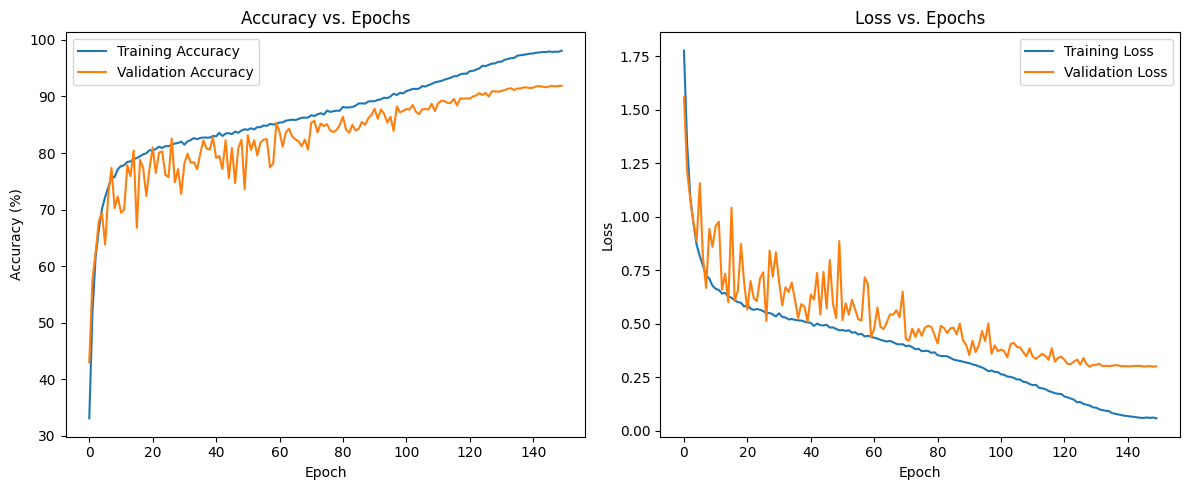

In [7]:
# 可视化训练过程 (★ 新增可视化部分)
# ==================================================================
plt.figure(figsize=(12, 5))  # 创建一个宽12高5的画布

# 绘制准确率曲线
plt.subplot(1, 2, 1)  # 将画布分为1行2列，此处使用第1个子图
plt.plot(history['train_acc'], label='Training Accuracy')  # 绘制训练准确率曲线
plt.plot(history['val_acc'], label='Validation Accuracy')  # 绘制验证集准确率曲线
plt.title('Accuracy vs. Epochs')  # 设置子图标题
plt.xlabel('Epoch')  # 设置x轴标签
plt.ylabel('Accuracy (%)')  # 设置y轴标签
plt.legend()  # 显示图例

# 绘制损失曲线
plt.subplot(1, 2, 2)  # 使用第2个子图
plt.plot(history['train_loss'], label='Training Loss')  # 绘制训练损失曲线
plt.plot(history['val_loss'], label='Validation Loss')  # 绘制验证集损失曲线
plt.title('Loss vs. Epochs')  # 设置子图标题
plt.xlabel('Epoch')  # 设置x轴标签
plt.ylabel('Loss')  # 设置y轴标签
plt.legend()  # 显示图例

plt.tight_layout()  # 自动调整子图以防止重叠
plt.show()  # 显示绘制好的图表

In [ ]:
# 如果是在colab里面运行代码，可以使用下面这个方法下载参数到本地
from google.colab import files
files.download('cifar10_improved_cnn_model.pth')